In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import ops
from geographiclib.geodesic import Geodesic
from shapely.geometry import LineString, MultiLineString
from scipy.ndimage.filters import gaussian_filter

# low-pass filter
def raster_filter(src, gamma):
    dst = src.copy()
    dst.values = gaussian_filter(dst.values.astype(np.float32),gamma,mode='constant')
    return dst

In [2]:
# plotting modules
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

## Define Parameters

In [3]:
# Gaussian filter sigma, km
sigmakm = 10

## Read Raster

In [4]:
# grav_29.1.10min.nc regridded from Open Sandwell and Smith Global Gravity Grid grav_29.1nc
da = xr.open_dataarray('grav_29.1.10min.nc').squeeze(drop=True)
da

<xarray.DataArray (lat: 960, lon: 2160)>
[2073600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * lat      (lat) float64 -79.92 -79.75 -79.58 -79.42 ... 79.58 79.75 79.92

## Raster Gaussian Filtering
Note: see other notebooks for processing on ellipsoid for better accuracy

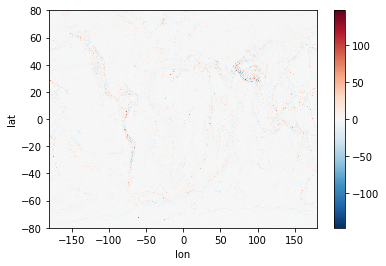

In [5]:
# roughly estimate filtering radius in pixels
radius = float(sigmakm/(100*da.lon.diff(dim='lon'))[0])
raster = da - raster_filter(da, radius)
raster.plot()

## Save Gaussian Filtered Raster

In [6]:
!rm -fr grav_29.1.10min.{sigmakm}km.nc
raster.to_netcdf(f'grav_29.1.10min.{sigmakm}km.nc')

## Vectorize Gaussian Filtered Raster

In [7]:
!gdal_contour -a z -i 20 grav_29.1.10min.{sigmakm}km.nc grav_29.1.10min.{sigmakm}km.shp

0...10...20...30...40...50...60...70...80...90...100 - done.


## Read vector file

In [8]:
df = gpd.read_file(f'grav_29.1.10min.{sigmakm}km.shp')
df.geometry = df.geometry.apply(lambda geom: MultiLineString([geom]) if geom.geom_type == 'LineString' else geom)
df = df.explode("geometry").reset_index(drop=True)
df

,ID,z,geometry
0,0,-20.0,"LINESTRING (-70.729 80.000, -70.729 79.917, -7..."
1,1,0.0,"LINESTRING (-146.868 80.000, -146.868 79.917, ..."
2,2,0.0,"LINESTRING (-143.161 80.000, -143.161 79.917, ..."
3,3,0.0,"LINESTRING (-121.541 80.000, -121.541 79.917, ..."
4,4,0.0,"LINESTRING (-118.995 80.000, -118.995 79.917, ..."
...,...,...,...
67564,67564,0.0,"LINESTRING (-26.168 -80.000, -26.168 -79.917, ..."
67565,67565,0.0,"LINESTRING (-1.229 -80.000, -1.229 -79.917, -1..."
67566,67566,0.0,"LINESTRING (-97.415 -80.000, -97.415 -79.917, ..."
67567,67567,0.0,"LINESTRING (25.332 -80.000, 25.332 -79.917, 25..."


<AxesSubplot:>

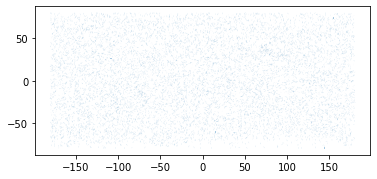

In [17]:
df.sample(10000).plot(alpha=0.5)

In [10]:
# helper function
def segmentize(line):
    return list(map(LineString, zip(line.coords[:-1], line.coords[1:])))

df['geom'] = df.geometry.apply(lambda geom: segmentize(geom))
df = df.explode("geom").reset_index(drop=True)
df = df.rename(columns={'geometry':'_','geom': 'geometry'}).drop(['_'], axis=1)
df

,ID,z,geometry
0,0,-20.0,"LINESTRING (-70.729 80.000, -70.729 79.917)"
1,0,-20.0,"LINESTRING (-70.729 79.917, -70.583 79.870)"
2,0,-20.0,"LINESTRING (-70.583 79.870, -70.417 79.859)"
3,0,-20.0,"LINESTRING (-70.417 79.859, -70.250 79.867)"
4,0,-20.0,"LINESTRING (-70.250 79.867, -70.083 79.868)"
...,...,...,...
1772767,67568,0.0,"LINESTRING (179.583 -71.544, 179.740 -71.417)"
1772768,67568,0.0,"LINESTRING (179.740 -71.417, 179.750 -71.409)"
1772769,67568,0.0,"LINESTRING (179.750 -71.409, 179.820 -71.417)"
1772770,67568,0.0,"LINESTRING (179.820 -71.417, 179.917 -71.432)"


In [11]:
# for inverse geodetic calculation
geod = Geodesic.WGS84

def inverse_radian_km(geom):
    # [[lon0, lat0], [lon1, lat1]]
    coords = np.asarray(geom.coords).ravel()
    #g = geod.Inverse(float(xy0.y), float(xy0.x), float(xy1.y), float(xy1.x))
    g = geod.Inverse(coords[1], coords[0], coords[3], coords[2])
    radian = np.pi*(90 + g['azi1'])/180
    radian = radian if radian<=np.pi else radian-2*np.pi
    return (radian, g['s12']/1000.0)

def angle_radian(geom):
    return inverse_radian_km(geom)[0]

def length_km(geom):
    return inverse_radian_km(geom)[1]

df['angle'] = df.geometry.apply(angle_radian)
df['length'] = df.geometry.apply(length_km)

In [12]:
# symmetrize directions
_df = df.copy()
_df['angle'] = df.angle.apply(lambda radian: radian-np.pi if radian>=0 else np.pi+radian)
df_sym = pd.concat([df, _df])

## Rose Diagram
https://matplotlib.org/1.2.1/examples/pylab_examples/polar_bar.html

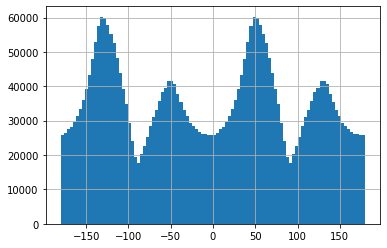

In [13]:
# make the same histogram plot as the rose diagram below
(180*df_sym['angle']/np.pi).hist(bins=100)
plt.show()

In [14]:
# Pandas 0.25.0+
angles = np.linspace(-np.pi, np.pi, 128+1, endpoint=True)
labels = (angles[1:] + angles[:-1])/2
df_sym['sector'] = labels[np.digitize(df_sym.angle, angles)-1]
df_sym_sector = df_sym.groupby(['sector']).agg(num = ('sector','count'),length = ('length','sum')).reset_index()

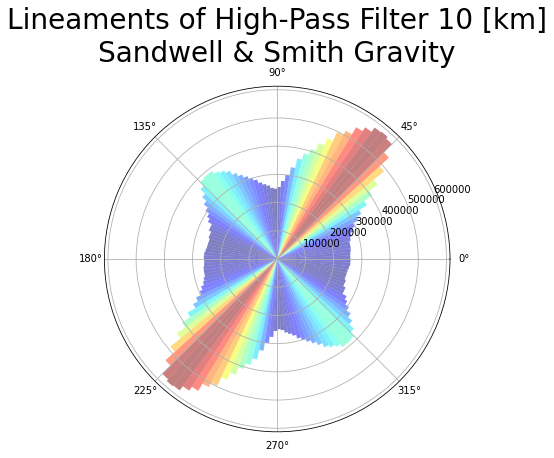

In [16]:
# force square figure and square axes looks better for polar, IMO
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

theta = df_sym_sector.sector.values
radii = df_sym_sector.length.values
width = np.diff(angles)[0]

bars = ax.bar(theta, radii, width=width, bottom=0.0)
for r,bar in zip(radii, bars):
    bar.set_facecolor( cm.jet((r-np.min(radii))/(np.max(radii)-np.min(radii))))
    bar.set_alpha(0.5)

plt.title(f'Lineaments of High-Pass Filter {sigmakm} [km]\nSandwell & Smith Gravity', fontsize=28)
plt.savefig(f'IsoLineaments of High-Pass Filter {sigmakm} [km] Sandwell & Smith Gravity.jpg', \
            bbox_inches='tight', dpi=150, pil_kwargs={'quality': 95})
plt.show()